In [20]:
# !pip install nltk
# !pip install textblob
# !pip install wordcloud

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)

In [14]:
df = pd.read_excel("../amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [16]:
######################## TEXT PRE-PROCESSING ###########################
df['Review'] = df['Review'].str.lower()

In [17]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [18]:
df['Review'] = df['Review'].str.replace('\d', '')

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [24]:
sil = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [25]:
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['Review'].head(10)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                happy
1     good quality material however panel mis-matched.
2    product fun bedroom windows.<br />imagery bit ...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck can't believe quality material...
5                                 look different photo
6    exactly looking for. heavy material. great pri...
7    looking picture, thought curtain would thinner...
8    much whiter thought would wasn’t really expect...
9    curtain picture shows. 3rd set ambesonne curta...
Name: Review, dtype: object

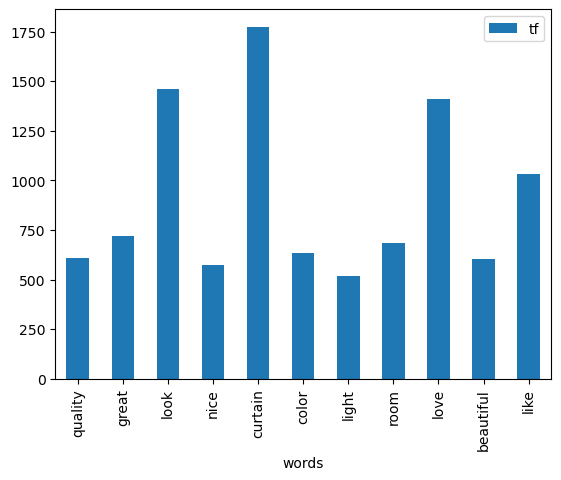

In [26]:
################# Text Visualization  #################
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

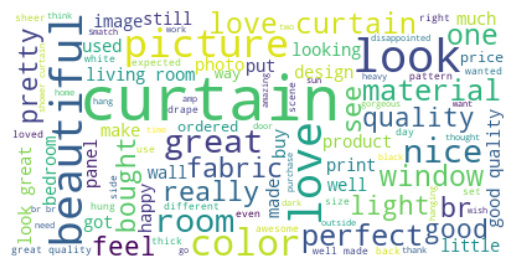

In [27]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
################# Sentimental Analysis  #################
#Let's create the SentimentIntensityAnalyzer object defined in the NLTK package in Python.
sia = SentimentIntensityAnalyzer()
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.537, 'pos': 0.463, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp...
7    {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [33]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.93
8   0.00
9   0.71
Name: Review, dtype: float64

In [34]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [35]:
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [36]:
df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg   3.45
pos   4.57
Name: Star, dtype: float64

In [37]:
# NOTE: By labeling the comments with SentimentIntensityAnalyzer, the dependent variable for the comment classification machine learning model was created.

In [38]:
################ ML Preparing #####################
# Test-Train
train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)

# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [39]:
################ MODELLING #####################
# 1. Modelling(Logistic Regression)

log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)
y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         neg       0.31      0.97      0.47        72
         pos       1.00      0.89      0.94      1331

    accuracy                           0.89      1403
   macro avg       0.66      0.93      0.71      1403
weighted avg       0.96      0.89      0.91      1403



In [40]:
cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

0.8538891713268937

In [41]:
# Randomly selecting comments from the data and asking the model.
random_review = pd.Series(df["Review"].sample(1).values)
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  look great bedroom! 
 Prediction: ['pos']


In [42]:
# 2. Modelling (Random Forest)
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8959405185561768